<a href="https://colab.research.google.com/github/wose70/HDB_Rental/blob/main/05_HDB_Rental_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

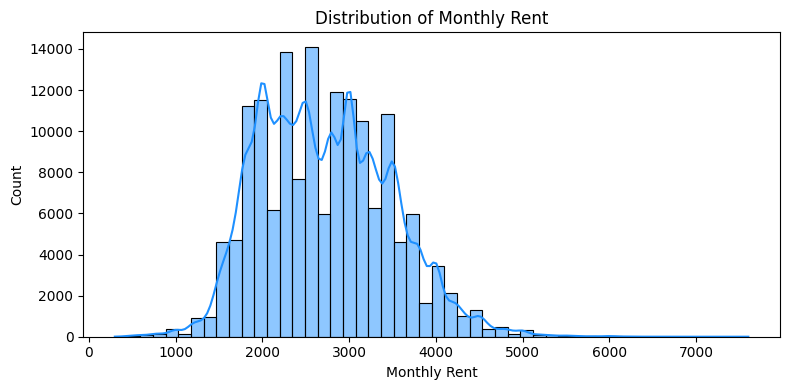

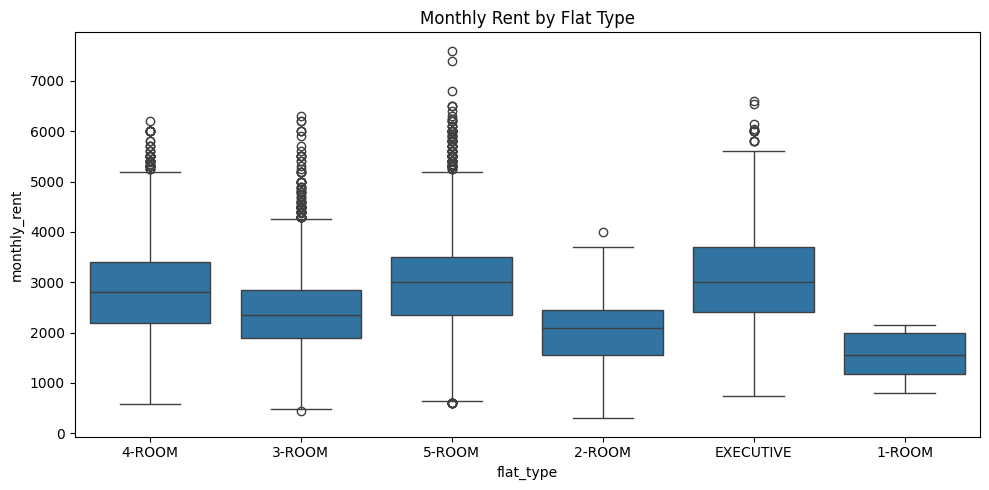

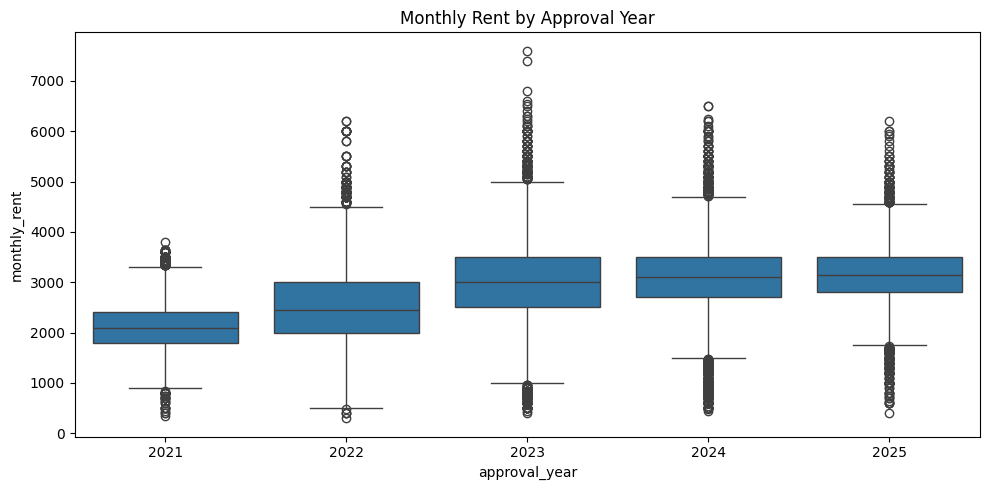

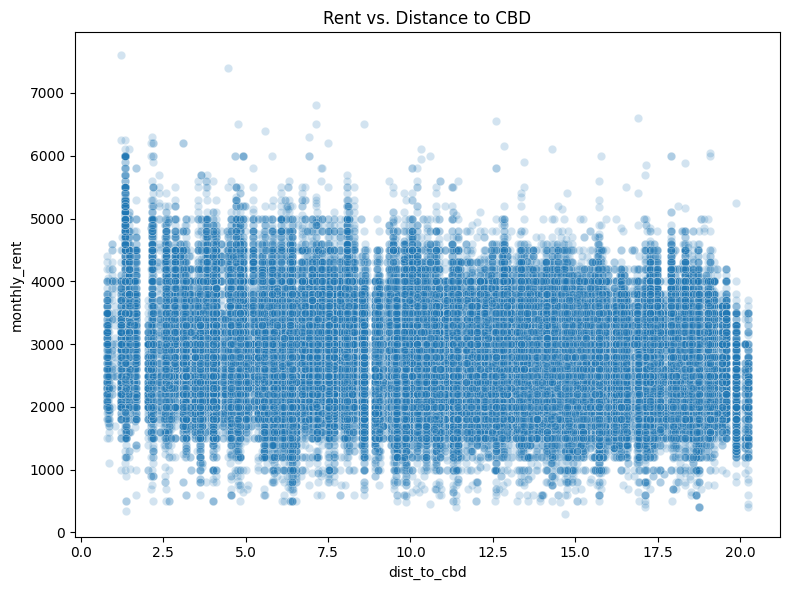

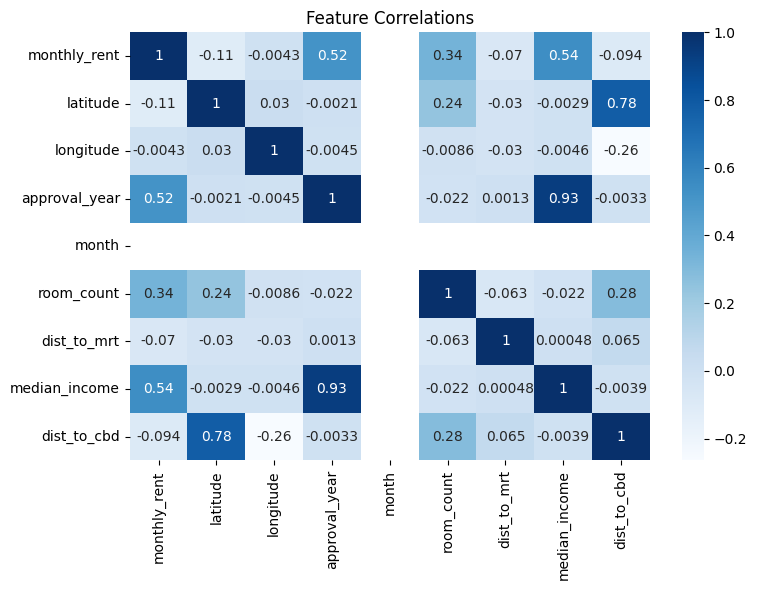

Epoch 1/100
3107/3107 - 14s - 5ms/step - loss: 604626.5000 - mae: 531.0593 - val_loss: 269555.3750 - val_mae: 393.4912
Epoch 2/100
3107/3107 - 16s - 5ms/step - loss: 323482.9688 - mae: 436.4428 - val_loss: 268265.1562 - val_mae: 387.8161
Epoch 3/100
3107/3107 - 11s - 3ms/step - loss: 320853.7812 - mae: 434.5507 - val_loss: 269079.4375 - val_mae: 392.6312
Epoch 4/100
3107/3107 - 11s - 4ms/step - loss: 319332.5312 - mae: 433.2910 - val_loss: 267214.8125 - val_mae: 391.1266
Epoch 5/100
3107/3107 - 20s - 6ms/step - loss: 317655.2812 - mae: 431.7436 - val_loss: 266655.0938 - val_mae: 390.9971
Epoch 6/100
3107/3107 - 10s - 3ms/step - loss: 317804.4688 - mae: 432.6393 - val_loss: 266435.6562 - val_mae: 390.2121
Epoch 7/100
3107/3107 - 10s - 3ms/step - loss: 315588.7188 - mae: 431.1936 - val_loss: 266546.8438 - val_mae: 390.7144
Epoch 8/100
3107/3107 - 11s - 4ms/step - loss: 315210.5625 - mae: 430.3095 - val_loss: 270098.2500 - val_mae: 392.5650
Epoch 9/100
3107/3107 - 21s - 7ms/step - loss: 3

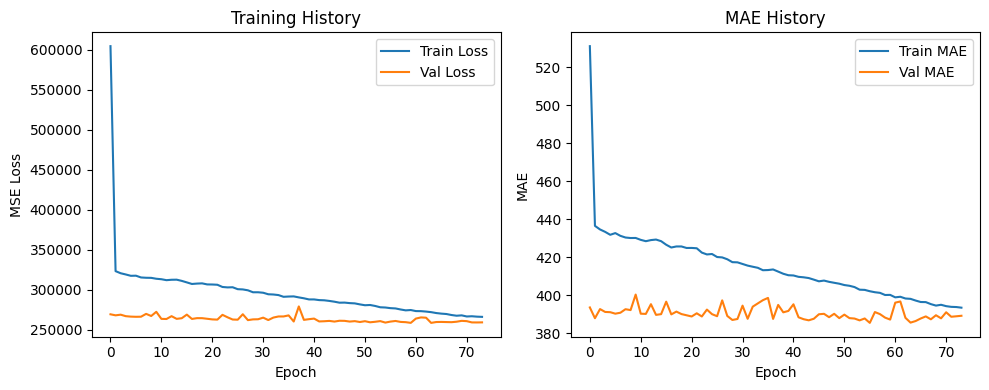

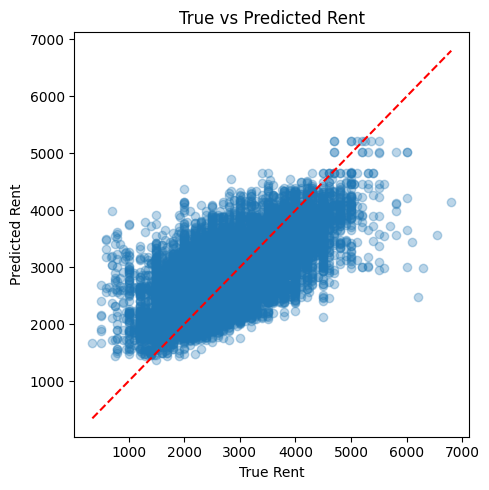

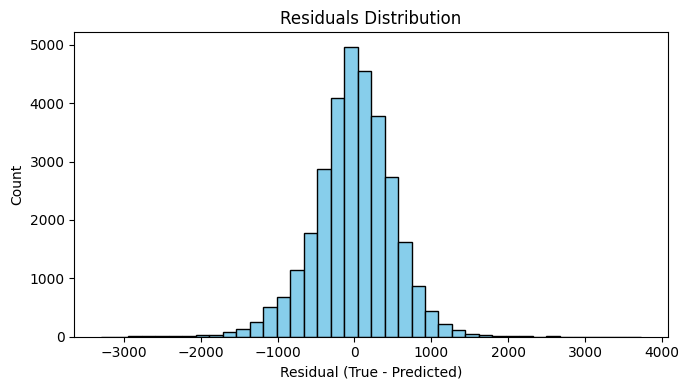


Sample Prediction:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step
Predicted rent: SGD $2194.33


In [11]:
"""
Rental Price Prediction with Deep Learning
Capstone Project (Student Version)
--------------------------------------
Predicts Singapore HDB rental prices using deep learning.
Key Features:
- Modular functions for each pipeline step.
- Uses street_name, latitude, longitude for spatial features.
- Incorporates MRT and income data.
- Optimized and concise for educational use.

Datasets Required:
- RentingOutofFlats2025.csv
- mrt_station.csv
- monthly household income.csv
"""

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def load_data():
    """Load rental, MRT, and income datasets."""
    rental = pd.read_csv("RentingOutofFlats2025.csv")
    mrt = pd.read_csv("mrt_station.csv")
    income = pd.read_csv("monthly household income.csv")
    return rental, mrt, income

def preprocess_rental(df):
    """Clean and preprocess the rental data."""
    # Convert date
    df["rent_approval_date"] = pd.to_datetime(df["rent_approval_date"], errors="coerce")
    df = df.dropna(subset=["rent_approval_date", "monthly_rent", "street_name", "latitude", "longitude"])
    # Extract year/month
    df["year"] = df["rent_approval_date"].dt.year
    df["month"] = df["rent_approval_date"].dt.month
    # Room count from flat_type
    df["room_count"] = df["flat_type"].str.extract(r"(\d+)").astype(float)
    df["room_count"].fillna(df["room_count"].median(), inplace=True)
    return df

def integrate_mrt(rental, mrt):
    """Add minimum distance to nearest MRT station as feature."""
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371  # km
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
        return 2*R*np.arcsin(np.sqrt(a))
    # Compute distances
    rental["dist_to_mrt"] = rental.apply(
        lambda row: np.min(haversine(row["latitude"], row["longitude"], mrt["latitude"], mrt["longitude"])), axis=1
    )
    return rental

def integrate_income(rental, income):
    """Merge median household income by approval year."""
    income = income.rename(columns={"medium": "median_income"})
    # Ensure rental has 'approval_year' (created during preprocessing)
    if "approval_year" not in rental.columns and "year" in rental.columns:
        rental = rental.rename(columns={"year": "approval_year"})
    # Merge on year
    rental = pd.merge(
        rental,
        income[["year", "median_income"]],
        left_on="approval_year",
        right_on="year",
        how="left"
    )
    rental["median_income"].fillna(rental["median_income"].median(), inplace=True)
    rental = rental.drop(columns=["year"])  # Drop extra 'year' from income.csv after merge
    return rental

def feature_engineering(df):
    """Create geospatial features and drop unused columns."""
    # Distance to CBD (Raffles Place)
    cbd_lat, cbd_lon = 1.2830, 103.8513
    df["dist_to_cbd"] = np.sqrt((df["latitude"] - cbd_lat)**2 + (df["longitude"] - cbd_lon)**2) * 111

    # Drop unused columns (excluding 'town')
    drop_cols = ["rent_approval_date", "block", "street_name"]
    df = df.drop([c for c in drop_cols if c in df.columns], axis=1)
    return df

def prepare_data(df):
    """Split features and target. Prepare pipeline."""
    X = df.drop("monthly_rent", axis=1)
    y = df["monthly_rent"]
    cat_cols = X.select_dtypes(include="object").columns.tolist()
    num_cols = X.select_dtypes(include=np.number).columns.tolist()
    # Pipelines
    num_pipe = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
    cat_pipe = Pipeline([("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
                         ("ohe", OneHotEncoder(handle_unknown="ignore"))])
    preprocessor = ColumnTransformer([
        ("num", num_pipe, num_cols),
        ("cat", cat_pipe, cat_cols)
    ])
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train_prep = preprocessor.fit_transform(X_train)
    X_test_prep = preprocessor.transform(X_test)
    return X_train_prep, X_test_prep, y_train, y_test, preprocessor

def build_deep_model(input_dim):
    """Define and compile the deep neural network."""
    model = Sequential([
        Dense(128, activation="relu", input_shape=(input_dim,)),
        Dropout(0.2),
        Dense(64, activation="relu"),
        Dropout(0.2),
        Dense(32, activation="relu"),
        Dense(1)
    ])
    model.compile(optimizer=Adam(0.001), loss="mse", metrics=["mae"])
    return model

def train_and_evaluate(X_train, X_test, y_train, y_test):
    """Train deep learning model and evaluate."""
    model = build_deep_model(X_train.shape[1])
    es = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True, verbose=1)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                        validation_split=0.2, callbacks=[es], verbose=2)
    # Evaluation
    loss, mae = model.evaluate(X_test, y_test, verbose=0)
    rmse = np.sqrt(loss)
    preds = model.predict(X_test).flatten()
    r2 = r2_score(y_test, preds)
    print(f"Deep Learning Results: RMSE={rmse:.2f}, MAE={mae:.2f}, R2={r2:.4f}")
    # Plot training history
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(history.history["loss"], label="Train Loss")
    plt.plot(history.history["val_loss"], label="Val Loss")
    plt.legend(); plt.xlabel("Epoch"); plt.ylabel("MSE Loss"); plt.title("Training History")
    plt.subplot(1,2,2)
    plt.plot(history.history["mae"], label="Train MAE")
    plt.plot(history.history["val_mae"], label="Val MAE")
    plt.legend(); plt.xlabel("Epoch"); plt.ylabel("MAE"); plt.title("MAE History")
    plt.tight_layout()
    plt.show()
    # Scatter plot: true vs pred
    plt.figure(figsize=(5,5))
    plt.scatter(y_test, preds, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
    plt.xlabel("True Rent"); plt.ylabel("Predicted Rent"); plt.title("True vs Predicted Rent")
    plt.tight_layout()
    plt.show()
    # Residual plot
    plt.figure(figsize=(7,4))
    plt.hist(y_test - preds, bins=40, color="skyblue", edgecolor="k")
    plt.xlabel("Residual (True - Predicted)"); plt.ylabel("Count"); plt.title("Residuals Distribution")
    plt.tight_layout()
    plt.show()
    return model

def visualize_eda(df):
    """Visual EDA: Distribution, boxplots, and correlation."""
    plt.figure(figsize=(8,4))
    sns.histplot(df["monthly_rent"], bins=50, kde=True, color="dodgerblue")
    plt.title("Distribution of Monthly Rent")
    plt.xlabel("Monthly Rent"); plt.ylabel("Count")
    plt.tight_layout(); plt.show()
    plt.figure(figsize=(10,5))
    sns.boxplot(x="flat_type", y="monthly_rent", data=df)
    plt.title("Monthly Rent by Flat Type")
    plt.tight_layout(); plt.show()
    plt.figure(figsize=(10,5))
    sns.boxplot(x="approval_year", y="monthly_rent", data=df)
    plt.title("Monthly Rent by Approval Year")
    plt.tight_layout(); plt.show()
    plt.figure(figsize=(8,6))
    sns.scatterplot(x="dist_to_cbd", y="monthly_rent", data=df, alpha=0.2)
    plt.title("Rent vs. Distance to CBD")
    plt.tight_layout(); plt.show()
    # Correlation heatmap
    plt.figure(figsize=(8,6))
    sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap="Blues")
    plt.title("Feature Correlations")
    plt.tight_layout(); plt.show()

def main():
    # 1. Load
    rental, mrt, income = load_data()
    # 2. Preprocess
    rental = preprocess_rental(rental)
    rental = integrate_mrt(rental, mrt)
    rental = integrate_income(rental, income)
    rental = feature_engineering(rental)
    # 3. Visual EDA
    visualize_eda(rental)
    # 4. Prepare data
    X_train, X_test, y_train, y_test, preprocessor = prepare_data(rental)
    # 5. Train & Evaluate
    model = train_and_evaluate(X_train, X_test, y_train, y_test)
    # 6. Example Prediction
    print("\nSample Prediction:")
    sample = rental.iloc[0:1].drop("monthly_rent", axis=1)
    sample_proc = preprocessor.transform(sample)
    pred = model.predict(sample_proc)[0][0]
    print(f"Predicted rent: SGD ${pred:.2f}")

if __name__ == "__main__":
    main()